In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

In [2]:
## SETUP
# protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr,crz, crx)
teleportation_circuit.draw()

q_0: 
       
  q_1: 
       
  q_2: 
       
crz: 1/
       
crx: 1/

## Step 1  
Telamon creates an entangled pair of qubits and gives one to Bob and one to Alice.  
The pair Telamon creates is a special pair called a Bell pair. In quantum Circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis(|+> and |->) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis.


In [3]:
def create_bell_pair(qc, a, b):
    qc.h(a)
    qc.cx(a, b)

In [4]:
## SETUP
# protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## Step 1
# In our case, Telamon engtangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

Let's say Alice owns $q_1$ and Bob owns $q_2$ after the part ways.

## STEP 2
Alice applies CNOT gate to $q_1$, controlled by $|\psi>$ (the qubit she is trying to send Bob).
Then Alice applies a Hadamard gate to the qubit ($|\psi>$) Alice is trying to send is $q_0$:

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
## SETUP
# Prototocl uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

## STEP 3
Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $|\psi>$, and stores this result in two classical bits. She then sends these two bits to Bob.

In [7]:
def measure_and_send(qc, a, b):
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)

In [8]:
## SETUP
## Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

## STEP 4
Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:
$00 -> Do nothing$  
$01 -> Apply X gate$  
$10 -> Apply Z gate$  
$11 -> Apply ZX gate$

In [9]:
# This funciton takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [10]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier()
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # use barrier to separater steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                  ║  ║       │   ┌──┴──┐
crz: 1/═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                  0  ║    ┌──┴──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

<IPython.core.display.Math object>

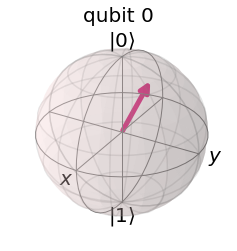

In [11]:
# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")

# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [12]:
def create_bell_pair(qc, q1, q2):
    qc.h(q1)
    qc.cx(q1, q2)
def alice_gates(qc, q1, q2):
    qc.cx(q1, q2)
    qc.h(q1)
def measure_and_send(qc, q1, q2):
    qc.barrier()
    qc.measure(q1, 0)
    qc.measure(q2, 1)
def bob_gates(qc, qubit, q1, q2):
    qc.x(qubit).c_if(q1, 1)
    qc.z(qubit).c_if(q2, 1)

In [13]:
## SETUP
qc = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qc, crz, crx)

# STEP 1
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.draw()

# STEP 2
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

# STEP 3
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

┌───┐ ░ ┌─┐   
  q_0: ────────────■──┤ H ├─░─┤M├───
       ┌───┐     ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■──┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐└───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├───────────░──╫──╫─
            └───┘           ░  ║  ║ 
crz: 1/════════════════════════╩══╬═
                               0  ║ 
                                  ║ 
crx: 1/═══════════════════════════╩═
                                  0

## 3. Simulating the Teleportation Protocol 

<IPython.core.display.Math object>

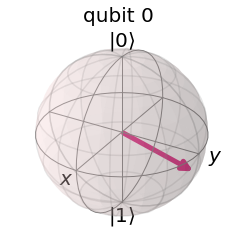

In [14]:
psi = random_state(1)

array_to_latex(psi, pretext="|\\psi\\rangle =")

plot_bloch_multivector(psi)

In [15]:
init_gate = Initialize(psi)
init_gate.label = "init"

## 3.2 Using the Statevector Simulator
We can use the statevector simulator to verify our qubit has been teleported.

In [16]:
## SETUP
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc. draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ 
                                             ║  ║ ┌──┴──┐   │   
crz: 1/══════════════════════════════════════╩══╬═╡ = 1 ╞═══╪═══
                                             0  ║ └─────┘┌──┴──┐
crx: 1/═════════════════════════════════════════╩════════╡ = 1 ╞
                                                0        └─────┘

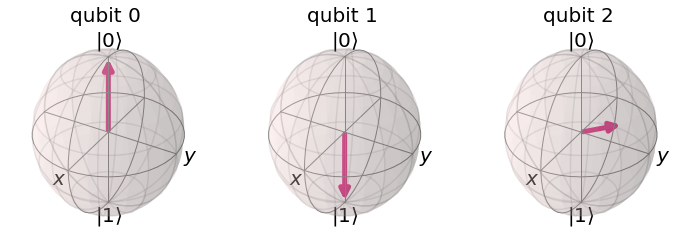

In [17]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

In [18]:
inverse_init_gate = init_gate.gates_to_uncompute()

In [19]:
## SETUP
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
create_bell_pair(qc, 1, 2)

## STEP 2
# send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# then sends her classical bits to Bob
measure_and_send(qc, 0, 1)


## STEP 4
# reverse the initialize process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

┌──────┐ ░                ┌───┐ ░ ┌─┐                   
  q_0: ┤ init ├─░─────────────■──┤ H ├─░─┤M├───────────────────
       └──────┘ ░ ┌───┐     ┌─┴─┐└───┘ ░ └╥┘┌─┐                
  q_1: ─────────░─┤ H ├──■──┤ X ├──────░──╫─┤M├────────────────
                ░ └───┘┌─┴─┐└───┘      ░  ║ └╥┘┌──────────────┐
  q_2: ─────────░──────┤ X ├───────────░──╫──╫─┤ disentangler ├
                ░      └───┘           ░  ║  ║ └──────────────┘
crz: 1/═══════════════════════════════════╩══╬═════════════════
                                          0  ║                 
                                             ║                 
crx: 1/══════════════════════════════════════╩═════════════════
                                             0

In [20]:
# Need to add a new classical register
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

┌──────┐ ░                ┌───┐ ░ ┌─┐                      
  q_0: ┤ init ├─░─────────────■──┤ H ├─░─┤M├──────────────────────
       └──────┘ ░ ┌───┐     ┌─┴─┐└───┘ ░ └╥┘┌─┐                   
  q_1: ─────────░─┤ H ├──■──┤ X ├──────░──╫─┤M├───────────────────
                ░ └───┘┌─┴─┐└───┘      ░  ║ └╥┘┌──────────────┐┌─┐
  q_2: ─────────░──────┤ X ├───────────░──╫──╫─┤ disentangler ├┤M├
                ░      └───┘           ░  ║  ║ └──────────────┘└╥┘
crz: 1/═══════════════════════════════════╩══╬══════════════════╬═
                                          0  ║                  ║ 
                                             ║                  ║ 
crx: 1/══════════════════════════════════════╩══════════════════╬═
                                             0                  ║ 
                                                                ║ 
 c0: 1/═════════════════════════════════════════════════════════╩═
                                                                0

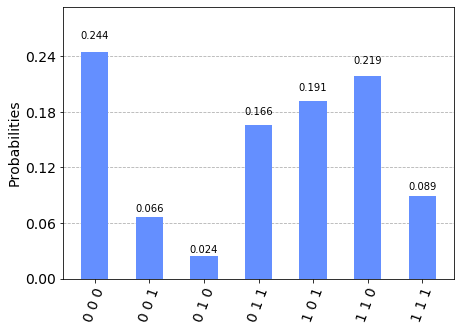

In [21]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

## 5. Teleportation on a Real Quantum Computer 

In [22]:
def new_bob_gates(qc, a, b, c):
    qc.cz(a, c)
    qc.cx(b, c)

In [23]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░                            
q_0: ┤ init ├─░────────────░───■──┤ H ├─░──■─────────────────────────
     └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░  │                         
q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──┼───■─────────────────────
              ░ └───┘┌─┴─┐ ░ └───┘      ░  │ ┌─┴─┐┌──────────────┐┌─┐
q_2: ─────────░──────┤ X ├─░────────────░──■─┤ X ├┤ disentangler ├┤M├
              ░      └───┘ ░            ░    └───┘└──────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════╩═
                                                                   0

In [24]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

/home/sheff/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [25]:
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)

{'0': 7553, '1': 639}


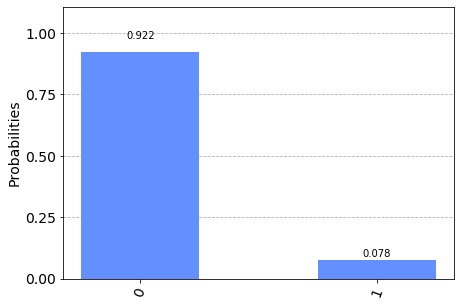

In [26]:
# Get the results and display them
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

In [27]:
error_rate_percent = sum([exp_measurement_result[result] for result in exp_measurement_result.keys() if result[0]=='1']) \
                    * 100./ sum(list(exp_measurement_result.values()))
print("The experimental error rate : ", error_rate_percent, "%")

The experimental error rate :  7.80029296875 %


In [29]:
def create_bell_pair(qc, q1, q2):
    qc.h(q1)
    qc.cx(q1, q2)
def alice_gates(qc, q1, q2):
    qc.cx(q1, q2)
    qc.h(q1)
def new_bob_gates(qc, q1, q2, q3):
    qc.cz(q1,q3)
    qc.cx(q2,q3)

In [30]:
qc = QuantumCircuit(3, 1)
qc.append(init_gate, [0])
qc.barrier()

#Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
#Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)
# We undo the initalization process
qc.append(inverse_init_gate, [2])
# See the results
qc.measure(2, 0)
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░                            
q_0: ┤ init ├─░────────────░───■──┤ H ├─░──■─────────────────────────
     └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░  │                         
q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──┼───■─────────────────────
              ░ └───┘┌─┴─┐ ░ └───┘      ░  │ ┌─┴─┐┌──────────────┐┌─┐
q_2: ─────────░──────┤ X ├─░────────────░──■─┤ X ├┤ disentangler ├┤M├
              ░      └───┘ ░            ░    └───┘└──────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════╩═
                                                                   0